# Data

I have taken the data regarding toronto from the wikipedia page-"https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=935851093 and geosaptial data from this file-'http://cocl.us/Geospatial_data' .Then I merge the two dataframes obtained to get a cosolidated locational data of toronto.After that i use venues data from foursqaure api to obtain restraunt category information .The restarunt's are then categorized into cusine types like-afgani,indian etc-manually.After that i perform k-clustering to ascertain weather there are dominant cusine types in neighbourhoods and if there are then what are these.

# Data cleaning

In [1]:
import pandas as pd

import requests

from bs4 import BeautifulSoup

In [2]:
req = requests.get("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=935851093")

soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]

df = pd.read_html(str(table))


neighborhood=pd.DataFrame(df[0])

In [3]:
df1=neighborhood.dropna(subset = ["Borough"])
df1.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Not assigned


In [4]:
df1 = df1.groupby('Postcode').agg({'Neighbourhood':'first', 
                             'Neighbourhood': ', '.join , 'Borough':'first'
                              }).reset_index()
df1.head()

,Postcode,Neighbourhood,Borough
0,M1A,Not assigned,Not assigned
1,M1B,"Rouge, Malvern",Scarborough
2,M1C,"Highland Creek, Rouge Hill, Port Union",Scarborough
3,M1E,"Guildwood, Morningside, West Hill",Scarborough
4,M1G,Woburn,Scarborough


In [5]:
df1.Borough.fillna(df1.Neighbourhood,inplace=True)
df1.head()

,Postcode,Neighbourhood,Borough
0,M1A,Not assigned,Not assigned
1,M1B,"Rouge, Malvern",Scarborough
2,M1C,"Highland Creek, Rouge Hill, Port Union",Scarborough
3,M1E,"Guildwood, Morningside, West Hill",Scarborough
4,M1G,Woburn,Scarborough


Above, i downloaded the postal code and neighbourhood information from wikipedia page. Then to clean the data i have performed foloowing actions-
1)remove rows having nan values in borugh column 
2)merging rows having same costal code

Downlaoding the geosaptial data and merging the two data frames

In [6]:
df = pd.read_csv('http://cocl.us/Geospatial_data')
df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
dfinal = df.merge(df1, how='inner', left_on='Postal Code', right_on='Postcode')
dfinal.head(10)

,Postal Code,Latitude,Longitude,Postcode,Neighbourhood,Borough
0,M1B,43.806686,-79.194353,M1B,"Rouge, Malvern",Scarborough
1,M1C,43.784535,-79.160497,M1C,"Highland Creek, Rouge Hill, Port Union",Scarborough
2,M1E,43.763573,-79.188711,M1E,"Guildwood, Morningside, West Hill",Scarborough
3,M1G,43.770992,-79.216917,M1G,Woburn,Scarborough
4,M1H,43.773136,-79.239476,M1H,Cedarbrae,Scarborough
5,M1J,43.744734,-79.239476,M1J,Scarborough Village,Scarborough
6,M1K,43.727929,-79.262029,M1K,"East Birchmount Park, Ionview, Kennedy Park",Scarborough
7,M1L,43.711112,-79.284577,M1L,"Clairlea, Golden Mile, Oakridge",Scarborough
8,M1M,43.716316,-79.239476,M1M,"Cliffcrest, Cliffside, Scarborough Village West",Scarborough
9,M1N,43.692657,-79.264848,M1N,"Birch Cliff, Cliffside West",Scarborough


# Data analysis

Downlaoding relevant dependecies

In [8]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
from pprint import pprint 



from geopy.geocoders import Nominatim 



import matplotlib.cm as cm 
import matplotlib.colors as colors 

from pandas.io.json import json_normalize 
from collections import Counter 

from sklearn.cluster import KMeans 
! pip install folium
import folium
print('Libraries imported.')

     |████████████████████████████████| 92kB 15.6MB/s eta 0:00:01
Libraries imported.


Generating map of toronto with neighbourhoods superimposed on it.

In [9]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [10]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)



for lat, lng, borough, neighborhood in zip(dfinal['Latitude'], dfinal['Longitude'], dfinal['Borough'], dfinal['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(Toronto_map)  
    
Toronto_map

# Fetching foursaquare venue category

In [11]:
CLIENT_ID = 'CE52W2D4UCAA0KJTKGZS2WKOC04CXC1551PPJJLPM5HXTMCX' 
CLIENT_SECRET = 'DQPSQALZQG5EOVAY1BKH3WF5C352RZB5QZM3FFFXCI02POUU'
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CE52W2D4UCAA0KJTKGZS2WKOC04CXC1551PPJJLPM5HXTMCX
CLIENT_SECRET:DQPSQALZQG5EOVAY1BKH3WF5C352RZB5QZM3FFFXCI02POUU


In [12]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
venue_results = requests.get(url).json()

In [13]:
venue_list = venue_results['response']['categories']

In [14]:
len(venue_list)

10

In [15]:
for data in venue_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [16]:
def flatten_Hierarchy(venue_list, checkParentID, category_dict, parent_id = ''):
    for data in venue_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(venue_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(venue_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [17]:
category_dict = flatten_Hierarchy(venue_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Exploring a neighbourhood to get a insight about what data is like

In [18]:
dfinal.loc[0, 'Neighbourhood']

'Rouge, Malvern'

In [19]:
neighborhood_latitude = dfinal.loc[0, 'Latitude'] 
neighborhood_longitude = dfinal.loc[0, 'Longitude'] 

neighborhood_name = dfinal.loc[0, 'Neighbourhood'] 
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


In [20]:
LIMIT = 1 
radius = 500 
categoryId = '4d4b7105d754a06374d81259' 



url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
results = requests.get(url).json()
results['response']['venues']

[{'id': '4f5d15b7e4b06784f91bad71',
  'name': 'Second Cup',
  'location': {'address': '60 Grand Marshall Drive',
   'crossStreet': 'Sheppard',
   'lat': 43.802164535542744,
   'lng': -79.19611362644378,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.802164535542744,
     'lng': -79.19611362644378}],
   'distance': 522,
   'cc': 'CA',
   'country': 'Canada',
   'formattedAddress': ['60 Grand Marshall Drive (Sheppard)', 'Canada']},
  'categories': [{'id': '4bf58dd8d48988d1e0931735',
    'name': 'Coffee Shop',
    'pluralName': 'Coffee Shops',
    'shortName': 'Coffee Shop',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1586918184',
  'hasPerk': False}]

# Streamlining data for better analysis

The category of venue searched is indian restraunt,which is cusine type.
But there will be general names like-bakery,coffe shop etc.These names need to be removed for our analysis.
Also there are certain venue categories,whose frequency is very low,and should not be considered in determining the dominant food cusine.Therefore i have taken only those venue categories whose frequency is above 30.
Also there some  venue categories which are overlapping and hence it is best to place them under one category.For eg-sushi restraunt can be renamed as japanese restraunt.I have renamed such categories based on google searches and some might not be  hundered percent right but i believe that it was necessary given the large number of venue categories and their overlapping nature.

In [21]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", 
            LIMIT)
            
        try:
           
            results = requests.get(url).json()['response']['venues']
            
           
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [22]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('toronto_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    toronto_venues = getNearbyFood(names=dfinal['Neighbourhood'],
                                        latitudes=dfinal['Latitude'],
                                        longitudes=dfinal['Longitude']
                                       )
    with open('toronto_food_venues.pkl', 'wb') as f:
        pickle.dump(toronto_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


In [23]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop
1,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
2,"Rouge, Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
3,"Rouge, Malvern",43.806686,-79.194353,Second Cup,43.802165,-79.196114,Coffee Shop
4,"Rouge, Malvern",43.806686,-79.194353,Tim Hortons / Esso,43.801863,-79.199296,Coffee Shop


In [24]:
toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Coffee Shop                        613
Pizza Place                        240
Café                               223
Restaurant                         219
Bakery                             183
Fast Food Restaurant               177
Chinese Restaurant                 144
Sandwich Place                     136
Italian Restaurant                 117
Caribbean Restaurant               104
Indian Restaurant                   92
Grocery Store                       77
Middle Eastern Restaurant           74
Burger Joint                        74
Food Court                          73
Sushi Restaurant                    68
Japanese Restaurant                 67
Thai Restaurant                     61
Asian Restaurant                    56
American Restaurant                 55
Mexican Restaurant                  55
Breakfast Spot                      54
Diner                               50
Bubble Tea Shop                     48
Korean Restaurant                   47
Deli / Bod

In [25]:
unique_categories = toronto_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Coffee Shop, Fast Food Restaurant, African Restaurant, Restaurant, Fried Chicken Joint, Sandwich Place, Indian Restaurant, Caribbean Restaurant, Chinese Restaurant, Burger Joint, Bakery, Greek Restaurant, Filipino Restaurant, Pizza Place, German Restaurant, Breakfast Spot, Japanese Restaurant, BBQ Joint, Café, Italian Restaurant, Mexican Restaurant, Fish & Chips Shop, Shawarma Place, Sports Bar, Salad Place, Juice Bar, Grocery Store, Korean Restaurant, French Restaurant, Snack Place, South Indian Restaurant, Hakka Restaurant, Asian Restaurant, Sushi Restaurant, Food Court, Halal Restaurant, Ice Cream Shop, Middle Eastern Restaurant, Food Truck, Wings Joint, Dessert Shop, Cajun / Creole Restaurant, Steakhouse, Deli / Bodega, Sri Lankan Restaurant, Thai Restaurant, Vegetarian / Vegan Restaurant, Falafel Restaurant, Diner, Gastropub, American Restaurant, Tea Room, Harbor / Marina, Bistro, Pakistani Restaurant, Hot Dog Joint, Chaat Place, Vietnamese Restaurant, Seafood Restaurant, Kebab Re

In [26]:
general=['Coffee Shop','Fast Food Restaurant','Fried Chicken Joint','Sandwich Place','Restaurant','Burger Joint','Bakery','Pizza Place',
         'Breakfast Spot','BBQ Join','Café','Fish & Chips Shop','Shawarma Place','Salad Place','Sports Bar','Grocery Store','Juice Bar','Snack Place',
         'Dessert Shop','Food Court','Halal Restaurant','Wings Joint','Food Truck','Ice Cream Shop','Vegetarian / Vegan Restaurant','Diner','Tea Room'
         ,'Gastropub','Bistro','Harbor / Marina','Hot Dog Joint','Chaat Place','Seafood Restaurant','Internet Cafe','Hotpot Restaurant','Bubble Tea Shop'
         ,'Noodle House','Hakka Restaurant','Hotpot Restaurant','Pastry Shop','Frozen Yogurt Shop','Chocolate Shop','Bar','Pub','Cafeteria','Buffet','Sake Bar'
         ,'Food & Drink Shop','Butcher','Gourmet Shop','Corporate Cafeteria','Pool Hall','Food','Event Space','Food Stand','Factory','Beach','Cupcake Shop'
         ,'Beer Bar','Brewery','Cocktail Bar','Supermarket','Comic Shop','Hardware Store','Smoothie Shop','Coworking Space','Pide Place','Food Service','Jazz Club'
         ,'Wine Bar','Creperie', 'Molecular Gastronomy Restaurant','Gay Bar','Shopping Mall','Theme Restaurant','Poke Place','Speakeasy',
         'Market','Convenience Store','Comfort Food Restaurant','Gluten-free Restaurant','Hotel Bar','Marijuana Dispensary','Hotel','Bike Shop','Pie Shop','Steakhouse'
        ,'Souvlaki Shop','Deli / Bodega','BBQ Joint','Bagel Shop','Office','Donut Shop','Irish Pub ','Empanada Restaurant','Mac & Cheese Joint']        

    

In [27]:
counts=toronto_venues['Venue Category'].value_counts()
counts



Coffee Shop                        613
Pizza Place                        240
Café                               223
Restaurant                         219
Bakery                             183
Fast Food Restaurant               177
Chinese Restaurant                 144
Sandwich Place                     136
Italian Restaurant                 117
Caribbean Restaurant               104
Indian Restaurant                   92
Grocery Store                       77
Middle Eastern Restaurant           74
Burger Joint                        74
Food Court                          73
Sushi Restaurant                    68
Japanese Restaurant                 67
Thai Restaurant                     61
Asian Restaurant                    56
Mexican Restaurant                  55
American Restaurant                 55
Breakfast Spot                      54
Diner                               50
Bubble Tea Shop                     48
Korean Restaurant                   47
Deli / Bodega            

In [28]:
counts[counts >30]
df1=toronto_venues[toronto_venues['Venue Category'].isin(counts[counts > 30].index)]

In [29]:
cusine_category=  list(set(unique_categories) - set(general))
print(', '.join(str(x) for x in cusine_category))

Malay Restaurant, Japanese Restaurant, Yemeni Restaurant, Modern European Restaurant, Mexican Restaurant, Argentinian Restaurant, Cantonese Restaurant, Greek Restaurant, Chinese Restaurant, Portuguese Restaurant, Mediterranean Restaurant, Chinese Breakfast Place, African Restaurant, Indian Restaurant, Asian Restaurant, Irish Pub, Italian Restaurant, Xinjiang Restaurant, Hawaiian Restaurant, Jewish Restaurant, New American Restaurant, Falafel Restaurant, Tapas Restaurant, Kebab Restaurant, Doner Restaurant, Eastern European Restaurant, Polish Restaurant, Middle Eastern Restaurant, American Restaurant, Ukrainian Restaurant, Moroccan Restaurant, Swiss Restaurant, Filipino Restaurant, French Restaurant, Ramen Restaurant, Shanghai Restaurant, South Indian Restaurant, Tibetan Restaurant, Scandinavian Restaurant, Ethiopian Restaurant, Taiwanese Restaurant, Taco Place, Brazilian Restaurant, Japanese Curry Restaurant, Vietnamese Restaurant, Egyptian Restaurant, Turkish Restaurant, Cajun / Creol

In [30]:
df1 = df1[toronto_venues['Venue Category'].isin(cusine_category)]
df1.head(5)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,"Rouge, Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian Restaurant
14,"Rouge, Malvern",43.806686,-79.194353,Just Soups,43.801286,-79.198802,Caribbean Restaurant
16,"Rouge, Malvern",43.806686,-79.194353,Charley's Exotic Cuisine,43.800982,-79.200233,Chinese Restaurant
18,"Rouge, Malvern",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
20,"Rouge, Malvern",43.806686,-79.194353,Mr. Greek,43.799853,-79.198234,Greek Restaurant


In [31]:
df1.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Chinese Restaurant           144
Italian Restaurant           117
Caribbean Restaurant         104
Indian Restaurant             92
Middle Eastern Restaurant     74
Sushi Restaurant              68
Japanese Restaurant           67
Thai Restaurant               61
Asian Restaurant              56
Mexican Restaurant            55
American Restaurant           55
Korean Restaurant             47
Vietnamese Restaurant         44
Greek Restaurant              35
Name: Venue Category, dtype: int64

In [32]:
df1["Venue Category"].rename({'Sushi Restaurant':'Japanese Restaurant','Asian Restaurant':'Indian Restaurant'
                                        ,'Burrito Place':'Mexican Restaurant','Falafel Restaurant':'Middle Eastern Restaurant','Tapas Restaurant':'Spanish Restaurant',
                                        'Dumpling Restaurant':'Chinese Restaurant','Dim Sum Restaurant':'Cantonese Restaurant','New American Restaurant':'American Restaurant'
                                        ,'Cantonese Restaurant':'Cantonese Restaurant','Taco Place':'Mexican Restaurant','South Indian Restaurant':'Indian Restaurant'
                                        ,'Poutine Place':'American Restaurant','Cajun / Creole Restaurant':'French Restaurant ','Indian Chinese Restaurant':'Indian Restaurant'
                                        ,'Kebab Restaurant':'Pakistani Restaurant','Szechuan Restaurant':'Chinese Restaurant','Arepa Restaurant':'South American Restaurant',
                                        'Chinese Breakfast Place':'Chinese Restaurant','Yemeni Restaurant':'Middle Eastern Restaurant','Colombian Restaurant':'South American Restaurant'
                                        ,'Cuban Restaurant':'South American Restaurant','Udon Restaurant':'Japanese Restaurant'},inplace=True)


In [33]:
df1.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
American Restaurant,55,55,55,55,55,55
Asian Restaurant,56,56,56,56,56,56
Caribbean Restaurant,104,104,104,104,104,104
Chinese Restaurant,144,144,144,144,144,144
Greek Restaurant,35,35,35,35,35,35
Indian Restaurant,92,92,92,92,92,92
Italian Restaurant,117,117,117,117,117,117
Japanese Restaurant,67,67,67,67,67,67
Korean Restaurant,47,47,47,47,47,47


In [34]:
one_hot = pd.get_dummies(df1[['Venue Category']], prefix="", prefix_sep="")
one_hot['Neighborhood'] = df1['Neighborhood'] 


fixed_columns = [one_hot.columns[-1]] + list(one_hot.columns[:-1])
one_hot = one_hot[fixed_columns] 

one_hot.head(5)


,Neighborhood,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant
11,"Rouge, Malvern",0,0,0,0,0,1,0,0,0,0,0,0,0,0
14,"Rouge, Malvern",0,0,1,0,0,0,0,0,0,0,0,0,0,0
16,"Rouge, Malvern",0,0,0,1,0,0,0,0,0,0,0,0,0,0
18,"Rouge, Malvern",0,0,1,0,0,0,0,0,0,0,0,0,0,0
20,"Rouge, Malvern",0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [35]:
torronto_grouped = one_hot.groupby('Neighborhood').mean().reset_index()
torronto_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant
0,"Adelaide, King, Richmond",0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.0,0.000000,0.25,0.000000
1,Agincourt,0.038462,0.038462,0.153846,0.615385,0.000000,0.076923,0.000000,0.038462,0.000000,0.000000,0.0,0.038462,0.00,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.095238,0.047619,0.666667,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.0,0.047619,0.00,0.047619
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.000000,0.357143,0.071429,0.071429,0.285714,0.071429,0.071429,0.000000,0.071429,0.0,0.000000,0.00,0.000000
4,"Alderwood, Long Branch",0.100000,0.200000,0.000000,0.100000,0.000000,0.100000,0.300000,0.000000,0.000000,0.000000,0.0,0.000000,0.20,0.000000


# Results

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [38]:
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torronto_grouped['Neighborhood']

In [39]:
for ind in np.arange(torronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Thai Restaurant,Mexican Restaurant,Japanese Restaurant,American Restaurant,Vietnamese Restaurant
1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Korean Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Caribbean Restaurant,Indian Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant
4,"Alderwood, Long Branch",Italian Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant


In [40]:
toronto_grouped_clustering = torronto_grouped.drop('Neighborhood', 1)

In [41]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

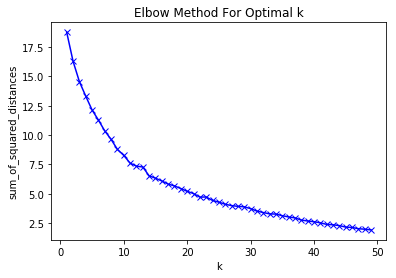

In [43]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method is used to calaculate the optimal number of clusters.Optimal k is at the point where rate of the above graph changes abruplty ,which is 10 in this case.

In [44]:
k = 10

toronto_grouped_clustering = torronto_grouped.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)


kmeans.labels_[0:38]

array([2, 4, 4, 6, 8, 1, 1, 3, 2, 9, 4, 8, 3, 4, 2, 2, 6, 9, 9, 2, 0, 1,
       2, 4, 0, 4, 4, 2, 8, 8, 8, 6, 2, 3, 9, 3, 0, 6], dtype=int32)

In [45]:
neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Thai Restaurant,Mexican Restaurant,Japanese Restaurant,American Restaurant,Vietnamese Restaurant
1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Korean Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Caribbean Restaurant,Indian Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant
4,"Alderwood, Long Branch",Italian Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant


In [46]:
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [47]:
toronto_merged = neighborhoods_venues_sorted.join(dfinal.set_index('Neighbourhood'), on='Neighborhood')
toronto_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
0,2,"Adelaide, King, Richmond",Thai Restaurant,Mexican Restaurant,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,M5H,43.650571,-79.384568,M5H,Downtown Toronto
1,4,Agincourt,Chinese Restaurant,Caribbean Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant,M1S,43.794200,-79.262029,M1S,Scarborough
2,4,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Korean Restaurant,M1V,43.815252,-79.284577,M1V,Scarborough
3,6,"Albion Gardens, Beaumond Heights, Humbergate, ...",Caribbean Restaurant,Indian Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,M9V,43.739416,-79.588437,M9V,Etobicoke
4,8,"Alderwood, Long Branch",Italian Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,M8W,43.602414,-79.543484,M8W,Etobicoke


In [48]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-10],
        fill=True,
        fill_color=rainbow[cluster-10],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [49]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[1:12]]
cluster_0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
20,"Chinatown, Grange Park, Kensington Market",Vietnamese Restaurant,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Caribbean Restaurant,M5T,43.653206,-79.400049,M5T,Downtown Toronto
24,"Clarks Corners, Sullivan, Tam O'Shanter",Vietnamese Restaurant,Chinese Restaurant,Asian Restaurant,Caribbean Restaurant,Thai Restaurant,M1T,43.781638,-79.304302,M1T,Scarborough
36,Downsview Central,Vietnamese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Greek Restaurant,Chinese Restaurant,M3M,43.728496,-79.495697,M3M,North York
38,Downsview West,Vietnamese Restaurant,Italian Restaurant,Chinese Restaurant,Caribbean Restaurant,Asian Restaurant,M3L,43.739015,-79.506944,M3L,North York
39,"Downsview, North Park, Upwood Park",Vietnamese Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Asian Restaurant,Thai Restaurant,M6L,43.713756,-79.490074,M6L,North York


In [50]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
5,"Bathurst Manor, Downsview North, Wilson Heights",Middle Eastern Restaurant,Sushi Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,M3H,43.754328,-79.442259,M3H,North York
6,Bayview Village,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Middle Eastern Restaurant,Korean Restaurant,M2K,43.786947,-79.385975,M2K,North York
21,Christie,Korean Restaurant,Italian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Middle Eastern Restaurant,M6G,43.669542,-79.422564,M6G,Downtown Toronto
54,Hillcrest Village,Chinese Restaurant,Korean Restaurant,Sushi Restaurant,Japanese Restaurant,Italian Restaurant,M2H,43.803762,-79.363452,M2H,North York
68,"Newtonbrook, Willowdale",Korean Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Indian Restaurant,Chinese Restaurant,M2M,43.789053,-79.408493,M2M,North York


In [51]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
0,"Adelaide, King, Richmond",Thai Restaurant,Mexican Restaurant,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,M5H,43.650571,-79.384568,M5H,Downtown Toronto
8,Berczy Park,Japanese Restaurant,Greek Restaurant,American Restaurant,Vietnamese Restaurant,Thai Restaurant,M5E,43.644771,-79.373306,M5E,Downtown Toronto
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",Sushi Restaurant,Mexican Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,M5V,43.628947,-79.394420,M5V,Downtown Toronto
15,"Cabbagetown, St. James Town",Japanese Restaurant,Thai Restaurant,Korean Restaurant,Italian Restaurant,Caribbean Restaurant,M4X,43.667967,-79.367675,M4X,Downtown Toronto
19,Central Bay Street,Mexican Restaurant,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,American Restaurant,M5G,43.657952,-79.387383,M5G,Downtown Toronto


In [52]:
cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
7,"Bedford Park, Lawrence Manor East",Thai Restaurant,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,M5M,43.733283,-79.419750,M5M,North York
12,Business Reply Mail Processing Centre 969 Eastern,Sushi Restaurant,Italian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Greek Restaurant,M7Y,43.662744,-79.321558,M7Y,East Toronto
33,Don Mills North,Thai Restaurant,Japanese Restaurant,Italian Restaurant,Asian Restaurant,Sushi Restaurant,M3B,43.745906,-79.352188,M3B,North York
35,"Dovercourt Village, Dufferin",Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Indian Restaurant,M6H,43.669005,-79.442259,M6H,West Toronto
45,"Flemingdon Park, Don Mills South",Sushi Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Italian Restaurant,M3C,43.725900,-79.340923,M3C,North York


In [53]:
cluster_4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant,M1S,43.794200,-79.262029,M1S,Scarborough
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Korean Restaurant,M1V,43.815252,-79.284577,M1V,Scarborough
10,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Middle Eastern Restaurant,M9C,43.643515,-79.577201,M9C,Etobicoke
13,"CFB Toronto, Downsview East",Chinese Restaurant,Italian Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Asian Restaurant,M3K,43.737473,-79.464763,M3K,North York
23,"Clairlea, Golden Mile, Oakridge",Chinese Restaurant,Indian Restaurant,Thai Restaurant,Mexican Restaurant,Vietnamese Restaurant,M1L,43.711112,-79.284577,M1L,Scarborough


In [54]:
cluster_5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
41,East Toronto,Greek Restaurant,Middle Eastern Restaurant,Italian Restaurant,American Restaurant,Vietnamese Restaurant,M4J,43.685347,-79.338106,M4J,East York
88,"The Danforth West, Riverdale",Greek Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,M4K,43.679557,-79.352188,M4K,East Toronto


In [55]:
cluster_6 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Caribbean Restaurant,Indian Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,M9V,43.739416,-79.588437,M9V,Etobicoke
16,Caledonia-Fairbanks,Caribbean Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Vietnamese Restaurant,Japanese Restaurant,M6E,43.689026,-79.453512,M6E,York
31,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",Chinese Restaurant,Caribbean Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Italian Restaurant,M6M,43.691116,-79.476013,M6M,York
37,Downsview Northwest,Caribbean Restaurant,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Middle Eastern Restaurant,M3N,43.761631,-79.520999,M3N,North York
42,"Emery, Humberlea",Italian Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,M9M,43.724766,-79.532242,M9M,North York


In [56]:
cluster_7 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
66,"Maryvale, Wexford",Middle Eastern Restaurant,Korean Restaurant,Vietnamese Restaurant,Italian Restaurant,Indian Restaurant,M1R,43.750072,-79.295849,M1R,Scarborough
81,"Silver Hills, York Mills",Middle Eastern Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,Mexican Restaurant,M2L,43.757490,-79.374714,M2L,North York


In [57]:
cluster_8 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[1:12]]
cluster_8.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
4,"Alderwood, Long Branch",Italian Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,M8W,43.602414,-79.543484,M8W,Etobicoke
11,"Brockton, Exhibition Place, Parkdale Village",Italian Restaurant,American Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,M6K,43.636847,-79.428191,M6K,West Toronto
28,Davisville,Italian Restaurant,Indian Restaurant,Thai Restaurant,Japanese Restaurant,Vietnamese Restaurant,M4S,43.704324,-79.388790,M4S,Central Toronto
29,Davisville North,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant,M4P,43.712751,-79.390197,M4P,Central Toronto
30,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Italian Restaurant,Middle Eastern Restaurant,Thai Restaurant,Japanese Restaurant,American Restaurant,M4V,43.686412,-79.400049,M4V,Central Toronto


In [58]:
cluster_9 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[1:12]]
cluster_9.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postal Code,Latitude,Longitude,Postcode,Borough
9,"Birch Cliff, Cliffside West",Indian Restaurant,Thai Restaurant,Asian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,M1N,43.692657,-79.264848,M1N,Scarborough
17,Canada Post Gateway Processing Centre,Mexican Restaurant,Middle Eastern Restaurant,Indian Restaurant,Greek Restaurant,Chinese Restaurant,M7R,43.636966,-79.615819,M7R,Mississauga
18,Cedarbrae,Indian Restaurant,Caribbean Restaurant,Asian Restaurant,Sushi Restaurant,Mexican Restaurant,M1H,43.773136,-79.239476,M1H,Scarborough
34,"Dorset Park, Scarborough Town Centre, Wexford ...",Asian Restaurant,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,M1P,43.757410,-79.273304,M1P,Scarborough
52,"High Park, The Junction South",Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,M6P,43.661608,-79.464763,M6P,West Toronto


# Conclusion

As can be infered from above analysis there is a dominant cusine type in almost all the clusters 
1)In cluster_0-vietnamese cusine is the domiant one.

2)In cluster_1-korean and chinese restraunts are more common.
3)In cluster_2-Japanese cusine is the domiant one.
4)In cluster_3-Thai cusine is the most common one.
5)In cluster_4-Chinese is the dominant cusine.
6)In cluster_5-Greek restraunts are most common.
7)In cluster_6-Carribean and chinese are the dominant cusine types.
8)In cluster_7-Middle eastern cusine is the domonant one.
9)In cluster_8-Italian is the dominant cusine.
10)In cluster_9-Indian restraunts are the most common one's.
However it should be kept in mind that only a few cluster such as cluster-9,8,0-clearly show the dominant cusine type.
Also some of the clusters like-2,0,8,3 &1 are geographically concenterated.